In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm, Normalize, LinearSegmentedColormap, SymLogNorm, ListedColormap, BoundaryNorm
from scipy.interpolate import interp1d
import sys
import os
import warnings

from petrobuffer.buffers import calcBuffer
from petrobuffer.conversions import get_relative_fo2

helios_source = '../../HELIOS/source'
if helios_source not in sys.path:
    sys.path.append(helios_source)
from species_database import species_lib

# get viridis colormap
cmap = plt.get_cmap('viridis')
cmap.set_bad(color='black')
# set dpi to 200
mpl.rcParams['figure.dpi'] = 200

In [2]:
# various CO2 phase diagarams from different sources
tco2_mar2, pco2_mar2 = np.loadtxt("../../FFP-Exomoons/plot_pt/co2_pt3.dat").T
tco2_mar6, pco2_mar6 = np.loadtxt("../../FFP-Exomoons/plot_pt/co2_pt6.dat").T

i_exclude = 4

appended_pco2 = np.append(pco2_mar2, pco2_mar6[:-i_exclude]*1e-5)
# sort, save sorting mask and sort tco2 similarly
mask = np.argsort(appended_pco2)
appended_pco2 = appended_pco2[mask]
appended_tco2 = np.append(tco2_mar2, tco2_mar6[:-i_exclude])[mask]

interpolated_tco2 = interp1d(np.log10(appended_pco2), appended_tco2, kind='linear', bounds_error=False, fill_value=(appended_tco2[0], appended_tco2[-1]))

# H2 phase diagram
th2_pt, ph2_pt = np.loadtxt("../../FFP-Exomoons/plot_pt/h2_pt.dat").T

# water data
T_freeze = 273.15 # K
T_boil = np.array([50, 100, 180, 310]) # deg C for P = [0.1, 1, 10, 100] bar
T_boil = T_boil + T_freeze # K
P_boil = np.array([0.1, 1, 10, 100]) # bar

interpolated_th2 = interp1d(np.log10(ph2_pt), th2_pt, kind='linear', bounds_error=False, fill_value=(th2_pt[0], th2_pt[-1]))

# plt.plot(interpolated_tco2(np.log10(np.logspace(2, -6, 100))), np.logspace(2, -6, 100), label='CO2')
# plt.plot(interpolated_th2(np.log10(np.logspace(2, -6, 100))), np.logspace(2, -6, 100), label='H2')
# plt.plot(T_boil, P_boil, '+', label='H2O')
# plt.yscale('log')
# plt.ylim(1.1e2, 0.9e-6)

In [3]:
# parameters
params = np.array(['P0', 'Tint', 'CplusO', 'CtoO'])

P0s = np.array([1e6, 1e7, 1e8]) # surface pressure in dyn/cm^2
Tints = np.array([50, 75, 100, 125, 150, 200, 250]) #, 300, 350]) # internal temperature in K

CplusOs = np.array([1e-3, 3.16e-3, 1e-2, 3.16e-2, 1e-1]) #, 3.16e-1, 1e0])
CtoOs = np.array([0.1, 0.59, 1.0])

folder = '../output/EqCond+Remove/'


In [4]:
def format_e_nums(num):
    num = f'{num:.2e}'.replace('0', '').replace('.e', 'e').replace('+', '')
    if num[-1] == 'e':
        num = num + '0'
    return num

def format_CtoO_float(f):
    if f == int(f):  # Check if it's a whole number
        return f"{f:.1f}"  # Format as integer if whole
    else:
        return f"{f:.10g}" # Use g format with sufficient precision.

def built_name(loop_over, P0, Tint, CplusO, CtoO, i_param=None, noCond=False, planet='Earth', add=''):
    if noCond:
        noCond = '_NoCond'
    else:
        noCond = ''

    if i_param == 0 or (i_param == None and loop_over in P0s):
        return f'{planet}_P0={format_e_nums(loop_over)}_Tint={Tint}{noCond}_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(CtoO)}' + add
    elif i_param == 1 or (i_param == None and loop_over in Tints):
        return f'{planet}_P0={format_e_nums(P0)}_Tint={loop_over}{noCond}_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(CtoO)}' + add
    elif i_param == 2 or (i_param == None and loop_over in CplusOs):
        return f'{planet}_P0={format_e_nums(P0)}_Tint={Tint}{noCond}_CplusO={format_e_nums(loop_over)}_CtoO={format_CtoO_float(CtoO)}' + add
    elif i_param == 3 or (i_param == None and loop_over in CtoOs):
        return f'{planet}_P0={format_e_nums(P0)}_Tint={Tint}{noCond}_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(loop_over)}' + add
    else:
        raise ValueError('Invalid loop_over value')

def extract_data(loop_overs, i_P0=0, i_Tint=0, i_CplusO=0, i_CtoO=0, noCond=False, planet='Earth', add=''):
        
    data_dict = {
        "inds": [],
        "PTs": [],
        "nHtots": [],
        "data": [],
        "atoms": [],
        "mols": [],
        "supersats": [],
        "dusts": [],
        "mus": [],
        "convergence": [],
        "n_iter": [],
        "ntots": [],
        "eps_atoms": [],
        "dust_to_gas": [],
        "dust_vol": [],
        "escape_time_yrs": [],
        "convective": [],
        'altitude': [],
    }

    for i, loop_over in enumerate(loop_overs):
        name = built_name(loop_over, P0s[i_P0], Tints[i_Tint], CplusOs[i_CplusO], CtoOs[i_CtoO], noCond=noCond, planet=planet, add=add)
        #print(name)

        path = folder + name + "/Static_Conc_{var}.dat"
        conv = True
        j = 0

        while True:
            with warnings.catch_warnings():
                warnings.simplefilter("error", UserWarning)
                try:
                    d = np.loadtxt(path.format(var=j), skiprows=3)
                    convergence_conditions = d[-1,2] != 1e-1
                    convergence_conditions = convergence_conditions and not np.all(d[:,0] == 1.001)
                    if convergence_conditions: # if pressure is not 0.1 dyn/cm^2 (=1e-7 bar), then the simulation did not converge
                        print(f'!GGchem did not converge for {name}!')
                        conv = False
                        j -= 1
                        break
                    j += 1
                except (FileNotFoundError, UserWarning) as warn:
                    if warn.__class__ == UserWarning:
                        print(f'!GGchem did not converge for {name}!')
                        conv = False
                    j -= 1
                    break

        if i == 0:
            dimension = np.genfromtxt(path.format(var=0), dtype=int, max_rows=1, skip_header=1)
            global n_elem, n_mol, n_dust, n_layers
            n_elem = dimension[0]
            n_mol = dimension[1]
            n_dust = dimension[2]
            n_layers = dimension[3]

            header = np.loadtxt(path.format(var=j), skiprows=2, max_rows=1, dtype=str)
            global atom_names, mol_names, dust_names
            atom_names = header[3:4+n_elem]
            mol_names = header[4+n_elem:4+n_elem+n_mol]
            dust_names = header[4+n_elem+n_mol:4+n_elem+n_mol+n_dust]
            dust_names = np.array([dust_name[1:] for dust_name in dust_names]) # Remove first character (S)
        
        if j == -1:
            d = np.zeros_like(d)
            d[:,:] = np.nan

            convective = np.zeros_like(mu)
            convective[:] = np.nan

            mu = np.zeros_like(mu)
            mu[:] = np.nan

            j = np.nan
        else:
            d = np.loadtxt(path.format(var=j), skiprows=3)
            data_dict["data"].append(d)

            convective = folder + name + f'/{name}_tp.dat'
            altitude = np.loadtxt(convective, skiprows=2, usecols=3)
            convective = np.loadtxt(convective, skiprows=2, usecols=6)

            escape_time_yrs = path[:-21] + f'escape.dat'
            # read the last number of the last row in the file
            with open(escape_time_yrs, 'r') as f:
                last_line = f.readlines()[-1]
                escape_time_yrs = float(last_line.split()[-1])

            try:
                mu = path[:-21] + f'vertical_mix_{j}.dat'
                mu = np.loadtxt(mu, skiprows=1, usecols=3)
            except FileNotFoundError:
                print('WARNING: ' + path[:-21] + f'vertical_mix_{j}.dat' + ' not found')
                mu = path[:-21] + f'vertical_mix_{j-1}.dat'
                mu = np.loadtxt(mu, skiprows=1, usecols=3)
                conv = False

        data_dict["PTs"].append(np.array([d[:, 2] * 1e-6, d[:, 0]]).T)  # convert pressure from dyn/cm^2 to bar
        data_dict["nHtots"].append(d[:, 1])
        data_dict["atoms"].append(d[:, 3:4+n_elem])
        data_dict["mols"].append(d[:, 4+n_elem:4+n_elem+n_mol])
        data_dict["supersats"].append(d[:, 4+n_elem+n_mol:4+n_elem+n_mol+n_dust])
        data_dict["dusts"].append(d[:, 4+n_elem+n_mol+n_dust:4+n_elem+n_mol+2*n_dust])
        data_dict["eps_atoms"].append(d[:, 4+n_elem+n_mol+2*n_dust:4+n_elem+n_mol+2*n_dust+n_elem])
        data_dict["dust_to_gas"].append(d[:, 4+n_elem+n_mol+2*n_dust+n_elem])
        data_dict["dust_vol"].append(d[:, 4+n_elem+n_mol+2*n_dust+n_elem+1])
        data_dict["inds"].append(i)
        data_dict["mus"].append(mu)
        data_dict["escape_time_yrs"].append(escape_time_yrs)
        data_dict["convective"].append(convective)
        data_dict["altitude"].append(altitude)

        data_dict["convergence"].append(conv)
        data_dict["n_iter"].append(j)
    
    if not data_dict["inds"]:
        data_dict["inds"] = np.empty((1))
        data_dict["PTs"] = np.empty((1, 2))
        data_dict["nHtots"] = np.empty((1))
        data_dict["data"] = np.empty((1, 1, 4+n_elem+n_mol+n_dust+7))
        data_dict["atoms"] = np.empty((1, 1, n_elem))
        data_dict["mols"] = np.empty((1, 1, n_mol))
        data_dict["supersats"] = np.empty((1, 1, n_dust))
        data_dict["dusts"] = np.empty((1, 1, n_dust))
        data_dict["eps_atoms"] = np.empty((1, 1, n_elem))
        data_dict["dust_to_gas"] = np.empty((1, 1))
        data_dict["dust_vol"] = np.empty((1, 1))

    data_dict["inds"] = np.array(data_dict["inds"])
    data_dict["PTs"] = np.array(data_dict["PTs"])
    data_dict["nHtots"] = np.array(data_dict["nHtots"])
    data_dict["data"] = np.array(data_dict["data"])
    data_dict["atoms"] = np.array(data_dict["atoms"])
    data_dict["mols"] = np.array(data_dict["mols"])
    data_dict["supersats"] = np.array(data_dict["supersats"])
    data_dict["dusts"] = np.array(data_dict["dusts"])
    data_dict["eps_atoms"] = np.array(data_dict["eps_atoms"])
    data_dict["dust_to_gas"] = np.array(data_dict["dust_to_gas"])
    data_dict["dust_vol"] = np.array(data_dict["dust_vol"])
    data_dict["convergence"] = np.array(data_dict["convergence"])
    data_dict["escape_time_yrs"] = np.array(data_dict["escape_time_yrs"])
    data_dict["convective"] = np.array(data_dict["convective"])
    data_dict["altitude"] = np.array(data_dict["altitude"])

    return name, data_dict

def convert(data_dict):

    for i in range(len(data_dict["data"])):
        n_tot = 10**data_dict["data"][i][:, 3:4+n_elem+n_mol]
        n_tot = np.sum(n_tot, axis=1)
        data_dict["ntots"].append(n_tot[:, None])
    data_dict["ntots"] = np.array(data_dict["ntots"])

    # convert atomic abundances (log(cm^-3)) to mixing ratios
    for i, atom in enumerate(data_dict["atoms"]):
        atom = 10**atom
        data_dict["atoms"][i] = atom / data_dict["ntots"][i]
    
    # convert molecular abundances (log(cm^-3)) to mixing ratios
    for i, mol in enumerate(data_dict["mols"]):
        mol = 10**mol
        data_dict["mols"][i] = mol / data_dict["ntots"][i]

    # convert dust abundances (log(cm^-3)) to mixing ratios
    for i in range(len(data_dict["dusts"])):
        data_dict["dusts"][i] = 10**(data_dict["dusts"][i]) * data_dict["nHtots"][i][:, None] / data_dict["ntots"][i]

    data_dict["eps_atoms"] = 10**data_dict["eps_atoms"]
    data_dict["eps_atoms"] = data_dict["eps_atoms"] / (np.sum(data_dict["eps_atoms"], axis=-1)[..., None])

    data_dict["dust_to_gas"] = 10**data_dict["dust_to_gas"]

    return data_dict

In [85]:
def get_BOA_TOA(i_temp, i_press, noCond=False):
    # read TOA and BOA temps for certain T and P with varying h2o and co2
    print('T =', Tints[i_temp], 'K , P =', P0s[i_press]/1e6, 'bar')

    BOAmatrix = np.empty((len(CplusOs), len(CtoOs)))
    BOAmatrix[:] = np.nan
    TOAmatrix = BOAmatrix.copy()

    loop_overs = CplusOs

    for i_CtoO in np.arange(len(CtoOs)):
        name, data_dict = extract_data(loop_overs, i_P0=i_press, i_Tint=i_temp, i_CtoO=i_CtoO, noCond=noCond)
        #name, inds, PTs, nHtots, data, atoms, mols, supersats, dusts, mus, conv = extract_data(loop_overs, i_P0=i_press, i_Tint=i_temp, i_CtoO=i_CtoO)
        
        conv = data_dict["convergence"]
        PTs = data_dict["PTs"]
        
        BOAmatrix[conv, i_CtoO] = [PTs[i][0, 1] for i in range(len(PTs)) if conv[i]]
        TOAmatrix[conv, i_CtoO] = [PTs[i][-1, 1] for i in range(len(PTs)) if conv[i]]
        #BOAmatrix[:, i_CtoO] = n_iter

    return BOAmatrix, TOAmatrix

def interpolate_BOA(i_press):

    i_temp = -1
    BOAmatrix = np.empty((len(CplusOs), len(CtoOs)))
    BOAmatrix[:] = np.nan
    while np.isnan(BOAmatrix).any() or np.nanmin(BOAmatrix) < T_freeze:
        try:
            i_temp += 1
            BOAmatrix = get_BOA_TOA(i_temp, i_press)[0]
            if not np.isnan(BOAmatrix).any() and np.nanmin(BOAmatrix) < T_freeze:
                # Don't do for last iteration!
                BOAmatrix_old = np.copy(BOAmatrix)
                i_temp_old = i_temp
        except FileNotFoundError:
            continue

    Tint_1 = Tints[i_temp_old]
    Tint_2 = Tints[i_temp]
    Tsurf_1 = BOAmatrix_old.flatten()[np.nanargmin(BOAmatrix)]
    Tsurf_2 = np.nanmin(BOAmatrix)
    Tint_f = (Tint_2 - Tint_1) * (T_freeze - Tsurf_1) / (Tsurf_2 - Tsurf_1) + Tint_1
    print('Interpolating BOA for T =', Tint_f, 'K, Tint(1,2) =', Tint_1, Tint_2, 'K, Tsurf(1,2) =', Tsurf_1, Tsurf_2)

    BOAmatrix_interp = np.empty((len(CplusOs), len(CtoOs)))
    BOAmatrix_interp[:] = np.nan

    BOAmatrix_interp = BOAmatrix_old.copy()
    BOAmatrix_interp += (Tint_f - Tint_1) * (BOAmatrix - BOAmatrix_old) / (Tint_2 - Tint_1)

    # test
    test = np.isclose(np.nanmin(BOAmatrix_interp), T_freeze, atol=1e-2)
    if test:
        print('Interpolation successful')
    else:
        print('Interpolation failed')

    return BOAmatrix_interp, Tint_f


def plot_BOA(BOAmatrix, vmin=100, vmax=1300, display_text=False, CpO_log=True, cmap=None):

    # log scale for colormap
    boa_vmin = np.log10(vmin)
    boa_vmax = np.log10(vmax)

    # Define the color segments with smooth transitions
    if cmap is None:
        colors = [
            (boa_vmin, "blue"),
            (np.log10(T_freeze-0.5), "lightblue"),
            (np.log10(T_freeze+0.5), "green"),
            # (np.log10((T_freeze+T_boil[i_press+1])/2), "green"),
            (np.log10(T_boil[i_press+1]-0.5), "lightgreen"),
            (np.log10(T_boil[i_press+1]+0.5), "darkorange"),
            (boa_vmax, "white")
        ]

        # Normalize the position values to be within [0, 1]
        positions = [(val - boa_vmin) / (boa_vmax - boa_vmin) for val, _ in colors]
        color_vals = [color for _, color in colors]

        # Create the custom colormap with smooth transitions
        boa_cmap = LinearSegmentedColormap.from_list("boa", list(zip(positions, color_vals)))

        ticks_label = np.array([100, 200, 300, 400, 600, 800, 1000, 1300])
        ticks_loc = ticks_label
        ticks_label = [f"{t:.0f}" for t in ticks_label]

        boa_norm = LogNorm(vmin=10**boa_vmin, vmax=10**boa_vmax)

    else:
        if type(cmap) == str:
            boa_cmap = plt.get_cmap(cmap)
        else:
            boa_cmap = cmap

        print(10**boa_vmin, 10**boa_vmax)
        boa_norm = Normalize(vmin=10**boa_vmin, vmax=10**boa_vmax)
    
    boa_cmap.set_bad(color='black')

    boa_im = plt.imshow(BOAmatrix, origin='lower', aspect='auto', cmap=boa_cmap, norm=boa_norm)
    if cmap is None:
        cbar = plt.colorbar(boa_im, label="Temperature [K]", ticks=[])
        cbar.set_ticks(ticks_loc)
        cbar.set_ticklabels(ticks_label)
    else:
        cbar = plt.colorbar(boa_im, label="Temperature [K]")
    plt.xticks(np.arange(len(CtoOs)), CtoOs)
    if CpO_log:
        plt.yticks(np.arange(len(CplusOs)), [f'{np.log10(CplusO):.2g}' for CplusO in CplusOs])
    else:
        plt.yticks(np.arange(len(CplusOs)), [f'{CplusO:.2g}' for CplusO in CplusOs])
    plt.xlabel("C/O")
    plt.ylabel(r"$\log_{10} \left( X_\mathrm{C+O} \right)$")
    plt.title(r"$\overline{T}_{BOA} = $" + f"{np.nanmean(BOAmatrix):.0f} K at " + r"$T_{int} = $" + f"{Tints[i_temp]} K, " + r"$P_{surf} = $" + f"{P0s[i_press]/1e6:g} bar")
    plt.tight_layout()

    if display_text:
        for (j,i),label in np.ndenumerate(BOAmatrix):
            plt.text(i,j,f'{label:.0f}',ha='center',va='center')

    return plt.gca()

def plot_TOA(TOAmatrix, vmin=15, vmax=200, cbar_ticks=[20, 50, 100, 200], display_text=False):
    
    plt.imshow(TOAmatrix, cmap=cmap, origin='lower', aspect='auto', norm=LogNorm(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(cmap=cmap, label="Temperature [K]")
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticks)
    plt.xticks(np.arange(len(CtoOs)), CtoOs)
    plt.yticks(np.arange(len(CplusOs)), [f'{np.log10(CplusO):.2g}' for CplusO in CplusOs])
    plt.xlabel("C/O")
    plt.ylabel("log(C+O / (C+O+H))")
    plt.title(r"$\overline{T}_{TOA} = $" + f"{np.nanmean(TOAmatrix):.0f} K at " + r"$T_{int} = $" + f"{Tints[i_temp]} K, " + r"$P_{surf} = $" + f"{P0s[i_press]/1e6:g} bar")
    plt.tight_layout()

    if display_text:
        for (j,i),label in np.ndenumerate(TOAmatrix):
            plt.text(i,j,f'{label:.0f}',ha='center',va='center')

    return plt.gca()

def set_white(ax):
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    ax.tick_params(axis='x', colors='white', which='both')  # Set color for both major and minor ticks
    ax.tick_params(axis='y', colors='white', which='both')  # Set color for both major and minor ticks

    try: # if colorbar is present
        ax.images[0].colorbar.ax.yaxis.label.set_color('white')
        ax.images[0].colorbar.ax.tick_params(axis='y', colors='white', which='both')
        ax.images[0].colorbar.outline.set_color('white')
        
        ax.images[0].colorbar.ax.xaxis.label.set_color('white')
        ax.images[0].colorbar.ax.tick_params(axis='x', colors='white', which='both')
        ax.images[0].colorbar.outline.set_color('white')
    except:
        pass

def increase_size(ax, linewidth=3, fontsize=14):
    for l in ax.lines:
        l.set_linewidth(linewidth)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(linewidth)
    ax.xaxis.set_tick_params(width=linewidth)
    ax.yaxis.set_tick_params(width=linewidth)
    fontsize = 14
    ax.xaxis.label.set_size(fontsize)
    ax.yaxis.label.set_size(fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    

T = 50 K , P = 100.0 bar
T = 75 K , P = 100.0 bar
Interpolating BOA for T = 56.09670411472931 K, Tint(1,2) = 50 75 K, Tsurf(1,2) = 241.045 372.694
Interpolation successful
273.0 312.9999999999999
273.15 278.6296700088872


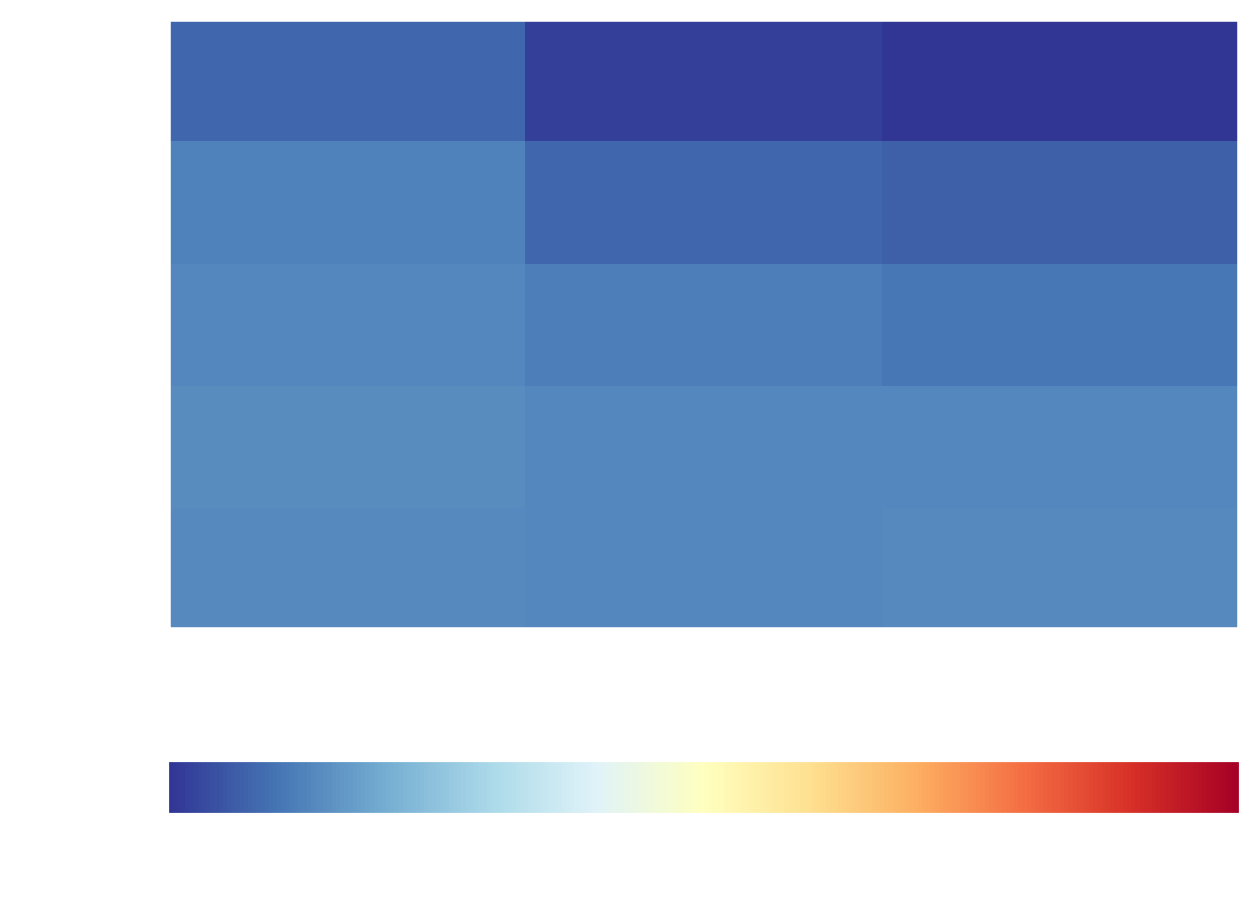

In [86]:
# plot example BOA and TOA matrices
i_temp = 2
i_press = 2

#BOAmatrix, TOAmatrix = get_BOA_TOA(i_temp, i_press, noCond=False)
BOAmatrix, Tint_f = interpolate_BOA(i_press)
axis = plot_BOA(BOAmatrix, display_text=False, CpO_log=True, cmap='RdYlBu_r', vmin=273, vmax=313)
print(np.nanmin(BOAmatrix), np.nanmax(BOAmatrix))

if True:
    plt.title('')
    # remove colorbar
    plt.gca().images[0].colorbar.remove()
    plt.gcf().colorbar(plt.gca().images[0], label="Temperature [K]", orientation='horizontal')
    #plt.gca().images[0].colorbar.ax.tick_params(axis='x', rotation=45)

    set_white(axis)
    increase_size(axis, linewidth=2, fontsize=12)
    plt.tight_layout()
    plt.savefig(f'images/ASES5/BOA_P0={P0s[i_press]/1e6:g}bar_Tint={Tint_f:.0f}K_colorbar.svg', transparent=True)
    plt.show()

In [7]:
plot_TOA(TOAmatrix, display_text=False)
print(np.nanmin(TOAmatrix), np.nanmax(TOAmatrix))

NameError: name 'TOAmatrix' is not defined

In [34]:
min_mean_max_BOA = np.zeros((5,2,3))

for i_temp in range(5):
    for i_press in range(2):
        try:
            BOAmatrix, TOAmatrix = get_BOA_TOA(i_temp, i_press, noCond=False)
        except FileNotFoundError:
            print(f'No data for T = {Tints[i_temp]} K, P = {P0s[i_press]/1e6:g} bar')
            continue
        ax = plot_BOA(BOAmatrix, CpO_log=False)
        ax.get_figure().savefig(f"images/{folder.split('/')[-2]}/BOA_{Tints[i_temp]}K_{P0s[i_press]/1e6:g}bar.png", dpi=200)
        # clear axis and colorbar
        plt.close(ax.get_figure())

        min_mean_max_BOA[i_temp, i_press, 0] = np.nanmin(BOAmatrix)
        min_mean_max_BOA[i_temp, i_press, 1] = np.nanmean(BOAmatrix)
        min_mean_max_BOA[i_temp, i_press, 2] = np.nanmax(BOAmatrix)

T = 50 K , P = 1.0 bar
!GGchem did not converge for Earth_P0=1e6_Tint=50_CplusO=3e-1_CtoO=0.59!
No data for T = 50 K, P = 1 bar
T = 50 K , P = 10.0 bar
!GGchem did not converge for Earth_P0=1e7_Tint=50_CplusO=3e-1_CtoO=0.59!
No data for T = 50 K, P = 10 bar
T = 100 K , P = 1.0 bar
!GGchem did not converge for Earth_P0=1e6_Tint=100_CplusO=3e-1_CtoO=0.59!
No data for T = 100 K, P = 1 bar
T = 100 K , P = 10.0 bar
T = 150 K , P = 1.0 bar
T = 150 K , P = 10.0 bar
T = 200 K , P = 1.0 bar
T = 200 K , P = 10.0 bar
T = 250 K , P = 1.0 bar
T = 250 K , P = 10.0 bar


In [35]:
min_mean_max_TOA = np.zeros((5,2,3))

for i_temp in range(5):
    for i_press in range(2):
        try:
            BOAmatrix, TOAmatrix = get_BOA_TOA(i_temp, i_press, noCond=False)
        except FileNotFoundError:
            print(f'No data for T = {Tints[i_temp]} K, P = {P0s[i_press]/1e6:g} bar')
        ax = plot_TOA(TOAmatrix)
        ax.get_figure().savefig(f"images/{folder.split('/')[-2]}/TOA_{Tints[i_temp]}K_{P0s[i_press]/1e6:g}bar.png", dpi=200)
        # clear axis and colorbar
        plt.close(ax.get_figure())

        min_mean_max_TOA[i_temp, i_press, 0] = np.nanmin(TOAmatrix)
        min_mean_max_TOA[i_temp, i_press, 1] = np.nanmean(TOAmatrix)
        min_mean_max_TOA[i_temp, i_press, 2] = np.nanmax(TOAmatrix)

T = 50 K , P = 1.0 bar
!GGchem did not converge for Earth_P0=1e6_Tint=50_CplusO=3e-1_CtoO=0.59!
No data for T = 50 K, P = 1 bar
T = 50 K , P = 10.0 bar
!GGchem did not converge for Earth_P0=1e7_Tint=50_CplusO=3e-1_CtoO=0.59!
No data for T = 50 K, P = 10 bar
T = 100 K , P = 1.0 bar
!GGchem did not converge for Earth_P0=1e6_Tint=100_CplusO=3e-1_CtoO=0.59!
No data for T = 100 K, P = 1 bar
T = 100 K , P = 10.0 bar
T = 150 K , P = 1.0 bar
T = 150 K , P = 10.0 bar
T = 200 K , P = 1.0 bar
T = 200 K , P = 10.0 bar
T = 250 K , P = 1.0 bar
T = 250 K , P = 10.0 bar


In [14]:
# plot other matrices

def get_other(i_temp, i_press, get, dust=False, rank=None, planet='Earth', add=''):
    # read TOA and BOA temps for certain T and P with varying h2o and co2
    print('T =', Tints[i_temp], 'K , P =', P0s[i_press]/1e6, 'bar')

    data_matrix = np.empty((len(CplusOs), len(CtoOs)))
    data_matrix[:] = np.nan

    loop_overs = CplusOs

    for i_CtoO in np.arange(len(CtoOs)):
        name, data_dict = extract_data(loop_overs, i_P0=i_press, i_Tint=i_temp, i_CtoO=i_CtoO, planet=planet, add=add)
        
        # Use the 'data' key from the dict instead of an external variable
        if data_dict['data'].shape[-1] == 0:
            continue

        # Convert data using the updated convert function returning a modified data_dict
        data_dict = convert(data_dict)
        conv = data_dict['convergence']

        if get == 'n_iter':
            if i_CtoO == 0:
                print(data_dict['n_iter'])
            data_matrix[conv, i_CtoO] = data_dict['n_iter']
        elif get == 'conv': # convergence! (not convection)
            data_matrix[:, i_CtoO] = conv
        elif get == 'dom_surf' or get == 'dominant at surface':
            if rank == None:
                rank = 1
            data_matrix[conv, i_CtoO] = np.argsort(data_dict['mols'][:, 0, :], axis=-1)[:,-rank]
        elif get == 'dom' or get == 'dominant':
            if rank == None:
                rank = 1
            data_matrix[conv, i_CtoO] = np.argsort(np.mean(data_dict['mols'], axis=-2), axis=-1)[:,-rank]
        elif get == 'escape_time_yrs':
            data_matrix[conv, i_CtoO] = data_dict['escape_time_yrs']
        
        else:
            if i_CtoO == 0:
                #print('shape:', data_dict['atoms'].shape)
                data_matrix = np.empty((len(CplusOs), len(CtoOs), data_dict['data'].shape[1]))
                data_matrix[:] = np.nan
            
            if get == 'mu' or get == 'mus':
                data_matrix[conv, i_CtoO] = data_dict['mus']
            elif get == 'altitude':
                data_matrix[conv, i_CtoO] = data_dict['altitude']
            elif get == 'P':
                data_matrix[conv, i_CtoO] = data_dict['PTs'][:, :, 0]
            elif get == 'T':
                data_matrix[conv, i_CtoO] = data_dict['PTs'][:, :, 1]
            elif get == 'nHtot':
                data_matrix[conv, i_CtoO] = data_dict['nHtots'][:, :]
            elif get == 'n_tot':
                data_matrix[conv, i_CtoO] = data_dict['ntots'][:, :, 0]
            elif get in atom_names:
                try:
                    data_matrix[conv, i_CtoO] = data_dict['atoms'][:, :, atom_names == get][:, :, 0]
                except Exception as e:
                    print('Error with', get, e)
            elif get in mol_names and not dust:
                data_matrix[conv, i_CtoO] = data_dict['mols'][:, :, mol_names == get][:, :, 0]
            elif get in dust_names and dust == 'supersats':
                data_matrix[conv, i_CtoO] = data_dict['supersats'][:, :, dust_names == get][:, :, 0]
            elif get in dust_names and dust == 'mrs':
                data_matrix[conv, i_CtoO] = data_dict['dusts'][:, :, dust_names == get][:, :, 0]
                print(np.max(data_matrix[conv, i_CtoO]))
            elif get[:3] == 'eps':
                atom_id = get.split('_')[-1]
                data_matrix[conv, i_CtoO] = data_dict['eps_atoms'][:, :, atom_names[1:] == atom_id][:, :, 0]
            elif get == 'CtoO':
                data_matrix[conv, i_CtoO] = data_dict['eps_atoms'][:, :, atom_names[1:] == 'C'][:, :, 0]
                data_matrix[conv, i_CtoO] /= data_dict['eps_atoms'][:, :, atom_names[1:] == 'O'][:, :, 0]
            elif get == 'dust_to_gas':
                data_matrix[conv, i_CtoO] = data_dict['dust_to_gas'][:, :]
            elif get == 'convective':
                data_matrix[conv, i_CtoO] = data_dict['convective'][:, :]
            else:
                raise ValueError('Invalid get value')
    
    return data_matrix

def plot_other(data_matrix, title, cbar_label, vmin=None, vmax=None, log=False, segmented=False, layer=None, display_text=False, CpO_log=True):

    if not segmented:
        if layer == None or layer == 'mean':
            if log:
                data_matrix = 10**np.nanmean(np.log10(data_matrix), axis=-1)
            else:
                data_matrix = np.nanmean(data_matrix, axis=-1)
        elif layer == 'min':
            data_matrix = np.nanmin(data_matrix, axis=-1)
        elif layer == 'max':
            data_matrix = np.nanmax(data_matrix, axis=-1)
        else:
            if len(data_matrix.shape) == 3:
                data_matrix = data_matrix[:,:,layer]
            else:
                data_matrix = data_matrix[:,:]

    if vmin == None:
        vmin = np.nanmin(data_matrix)

    if vmax == None:
        vmax = np.nanmax(data_matrix)

    #assert vmin < vmax, 'vmin must be less than vmax'

    if log:
        if vmin*vmax < 0:
            norm = SymLogNorm(linthresh=np.nanmin(np.abs(data_matrix)), vmin=vmin, vmax=vmax)
        else:
            norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = None

    # build cmaps
    if segmented: # special case for n_iter
        if cbar_label == 'n_iter':
            n = int(vmax - vmin + 1)
            cbar_label = "Number of iterations"
        elif cbar_label == 'dominant' or cbar_label == 'dom':
            n = len(np.unique(data_matrix[~np.isnan(data_matrix)]))
            n = np.maximum(n, 2)
            mol_mask = np.int32(np.unique(data_matrix[~np.isnan(data_matrix)]))
            for i,ind in enumerate( np.unique(data_matrix[~np.isnan(data_matrix)]) ):
                data_matrix[data_matrix == ind] = i
            vmin = 0
            vmax = n
            cbar_label = "Dominant species (mean abundance over layers)"
        elif cbar_label == 'dominant at surface' or cbar_label == 'dom_surf':
            n = len(np.unique(data_matrix[~np.isnan(data_matrix)]))
            n = np.maximum(n, 2)
            mol_mask = np.int32(np.unique(data_matrix[~np.isnan(data_matrix)]))
            for i,ind in enumerate( np.unique(data_matrix[~np.isnan(data_matrix)]) ):
                data_matrix[data_matrix == ind] = i
            vmin = 0
            vmax = n
            cbar_label = "Dominant species at surface"
        # build segmented viridis colormap with n colors
        colors = [cmap(i / (n - 1)) for i in range(n)]
        custom_cmap = ListedColormap(colors)
        bounds = vmin + np.arange(n+1) - 0.5
        norm = mpl.colors.BoundaryNorm(bounds, custom_cmap.N)
    else:
        custom_cmap = plt.get_cmap('viridis')
        custom_cmap.set_bad(color='black')

    if norm is None:
        plt.imshow(data_matrix, cmap=custom_cmap, origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(data_matrix, cmap=custom_cmap, origin='lower', aspect='auto', norm=norm)
    
    cbar = plt.colorbar(cmap=custom_cmap, label=cbar_label)
    if segmented:
        cbar_ticks = np.arange(vmin, vmax+1)
        cbar.minorticks_off()
        cbar.set_ticks(cbar_ticks)
    
    plt.xticks(np.arange(len(CtoOs)), CtoOs)
    if CpO_log:
        plt.yticks(np.arange(len(CplusOs)), [f'{np.log10(CplusO):.2g}' for CplusO in CplusOs])
    else:
        plt.yticks(np.arange(len(CplusOs)), [f'{CplusO:.2g}' for CplusO in CplusOs])
    plt.xlabel("C/O")
    plt.ylabel("log(C+O / (C+O+H))")
    plt.title(title)
    plt.tight_layout()

    if display_text:
        if segmented:
            for (j,i),label in np.ndenumerate(data_matrix):
                if cbar_label == "Number of iterations":
                    plt.text(i,j,f'{label:.0f}',ha='center',va='center')
                else:
                    # for plotting dominant species
                    if not np.isnan(label):
                        plt.text(i,j,mol_names[mol_mask][int(label)],ha='center',va='center')
                        # delete colorbar
                        if i == 0 and j == 0:
                            cbar.remove()
        else:
            if np.min(np.abs(data_matrix)) > 1e-2 and np.max(np.abs(data_matrix)) < 1e2:
                for (j,i),label in np.ndenumerate(data_matrix):
                    plt.text(i,j,f'{label:.1f}',ha='center',va='center')
            else:
                for (j,i),label in np.ndenumerate(data_matrix):
                    plt.text(i,j,f'{label:.1e}',ha='center',va='center')

    return plt.gca()

T = 150 K , P = 10.0 bar
6.904036434398712e-28 0.20618324255430875


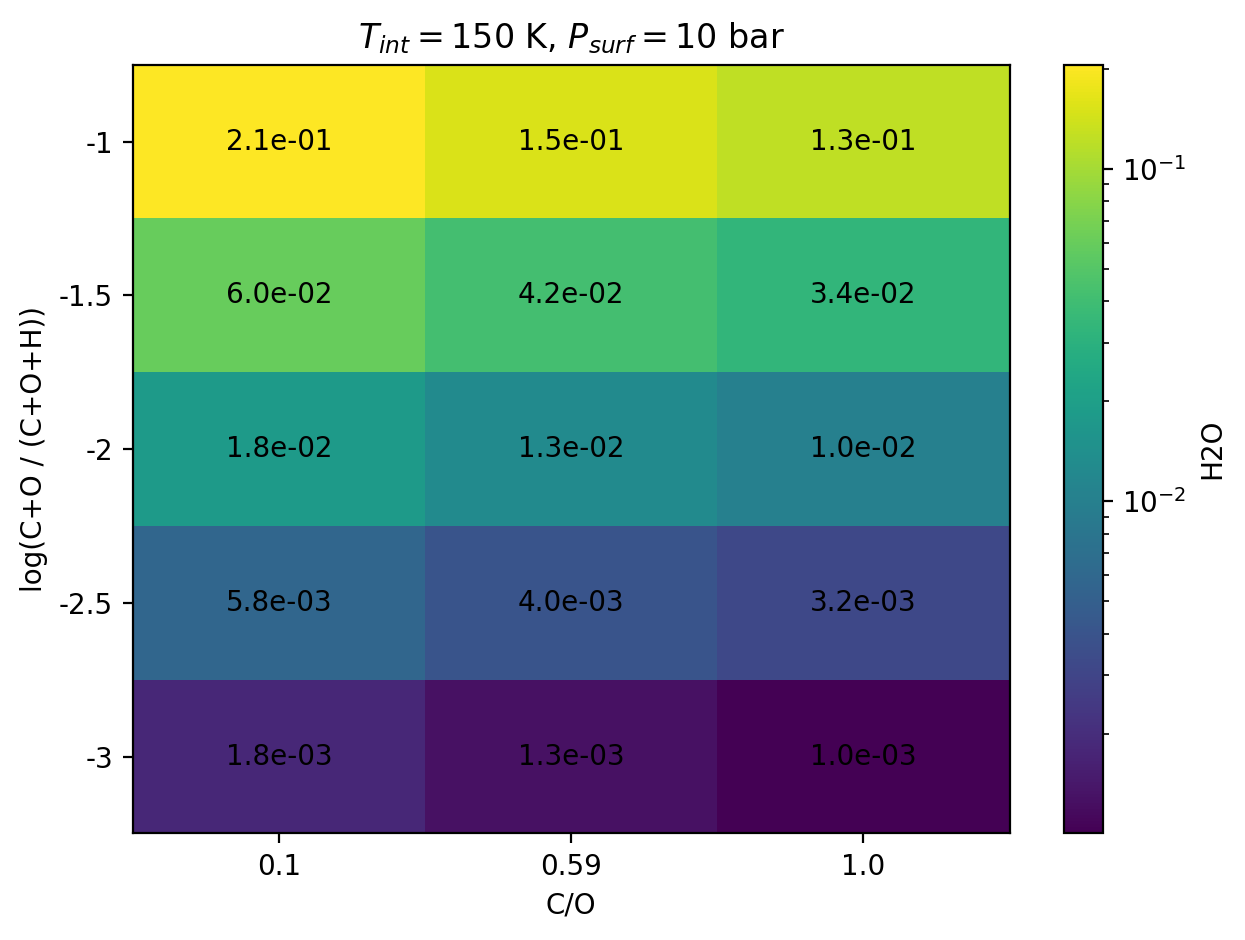

In [18]:
i_temp = 4
i_press = 1
add = ''

get = 'H2O'

# set dust=True for supersaturation
if get == 'fO2':
    buffer = 'IW'

    fO2_surf = get_other(i_temp, i_press, get='O2', dust=False, rank=None, planet='Earth', add=add)[:,:,0]
    fO2_surf = np.log10(fO2_surf)
    Tsurf = get_other(i_temp, i_press, get='T', dust=False, rank=None, planet='Earth', add=add)[:,:,0]
    Psurf = get_other(i_temp, i_press, get='P', dust=False, rank=None, planet='Earth', add=add)[:,:,0]

    data_matrix = np.zeros_like(fO2_surf)
    for i in range(len(CplusOs)):
        for j in range(len(CtoOs)):
            data_matrix[i, j] = get_relative_fo2(fO2_surf[i, j], buffer, Tsurf[i, j], Psurf[i, j])

    get = r'$\Delta$' + buffer

else:
    data_matrix = get_other(i_temp, i_press, get=get, dust=False, rank=None, planet='Earth', add=add)

print(np.nanmin(data_matrix), np.nanmax(data_matrix))

title = r"$T_{int} = $" + f"{Tints[i_temp]} K, " + r"$P_{surf} = $" + f"{P0s[i_press]/1e6:g} bar"

#data_matrix = data_matrix / CtoOs[:,None] #CtoO enhancement

layer = 0 #'rcb'
if layer == 'rcb':
    convective = get_other(i_temp, i_press, get='convective', dust=False, rank=None, planet='Earth')
    layer = np.argmax(convective == 0, axis=-1) - 1
    indices = np.indices(layer.shape)
    data_matrix = data_matrix[indices[0], indices[1], layer]

# segmented=True for n_iter

# if layer=mean and log=True, the mean is calculated in log space
ax = plot_other(data_matrix, title, get, log=True, segmented=False, vmin=None, vmax=None, layer=layer, display_text=True, CpO_log=True)


T = 150 K , P = 10.0 bar
T = 150 K , P = 10.0 bar
-1.3877787807814457e-16 0.20618324255431209


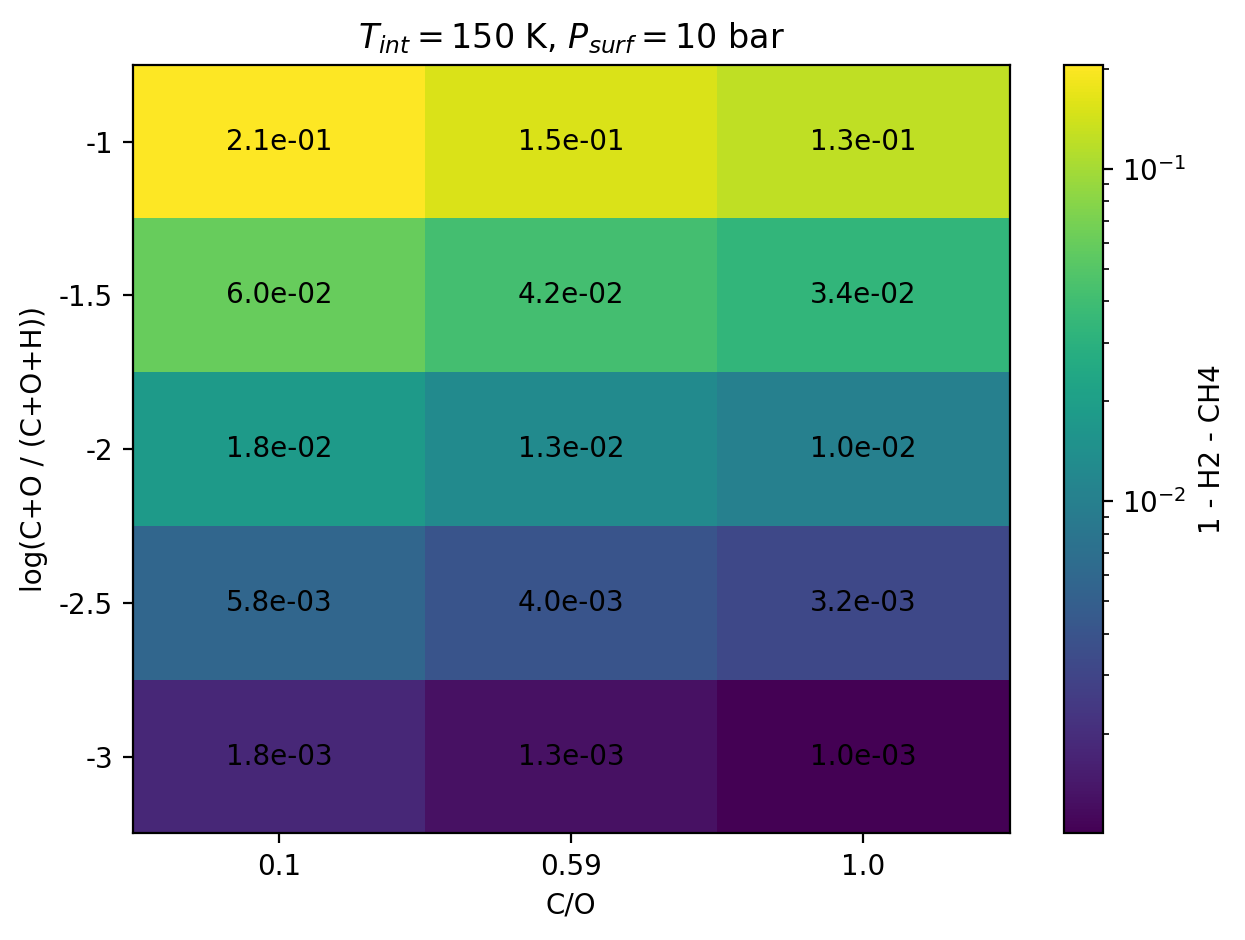

In [10]:
i_temp = 4
i_press = 1

# set dust=True for supersaturation
h2_matrix = get_other(i_temp, i_press, get='H2', dust=False, rank=None)
ch4_matrix = get_other(i_temp, i_press, get='CH4', dust=False, rank=None)
data_matrix = 1 - h2_matrix - ch4_matrix
print(np.nanmin(data_matrix), np.nanmax(data_matrix))

title = r"$T_{int} = $" + f"{Tints[i_temp]} K, " + r"$P_{surf} = $" + f"{P0s[i_press]/1e6:g} bar"

#data_matrix = data_matrix / CtoOs[:,None] #CtoO enhancement

# segmented=True for n_iter
# if layer=mean and log=True, the mean is calculated in log space
ax = plot_other(data_matrix, title, '1 - H2 - CH4', log=True, segmented=False, vmin=None, vmax=None, layer='max', display_text=True)


In [56]:
planet_r_dict = {
    'Earth': 6371e5  # cm
}


def get_total_liquid_water_mass(i_temp, i_press, combine=False, planet='Earth'):
    """
    Calculate the total mass of liquid water in the atmosphere.
    :param atmo_dict: dictionary containing the atmosphere data
    :param combine: if True, combine H2O and H2O[l]
    :return: total mass of liquid water in the atmosphere
    """
    h2o_mmw = 18.01528  # g/mol

    # get the mass of liquid water in each layer
    n_tots = get_other(i_temp, i_press, get='n_tot', planet=planet)
    h2o = get_other(i_temp, i_press, get='H2O', dust='mrs', planet=planet) * n_tots * h2o_mmw * 1.66e-24 # mr -> cm^-3 -> g/cm^3
    h2o_l = get_other(i_temp, i_press, get='H2O[l]', dust='mrs', planet=planet) * n_tots * h2o_mmw *1.66e-24 # mr -> cm^-3 -> g/cm^3

    # get altitude
    altitude = get_other(i_temp, i_press, get='altitude', planet=planet)
    if planet in planet_r_dict.keys():
        planet_r = planet_r_dict[planet]
        altitude = altitude + planet_r
    else:
        raise KeyError('Invalid planet name')

    # integrate over layers
    if combine:
        h2o = h2o + h2o_l
        h2o_l = np.zeros_like(h2o)

    # integrate over layers (4pi*rho*r^2)
    h2o_mass = 4 * np.pi * np.trapz(h2o * (altitude**2), x=altitude, axis=-1)
    h2o_l_mass = 4 * np.pi * np.trapz(h2o_l * (altitude**2), x=altitude, axis=-1)

    return h2o_mass, h2o_l_mass

earth_ocean = 1.4e24  # g

T = 50 K , P = 100.0 bar
T = 50 K , P = 100.0 bar
0.25973272531790226
0.17969062482777587
0.1428546969112591
T = 50 K , P = 100.0 bar
2.639970571388375e-300
2.8763561201215058e-300
2.999986468987317e-300
T = 50 K , P = 100.0 bar


<Axes: title={'center': '$T_{int} = $50 K, $P_{surf} = $100 bar'}, xlabel='C/O', ylabel='log(C+O / (C+O+H))'>

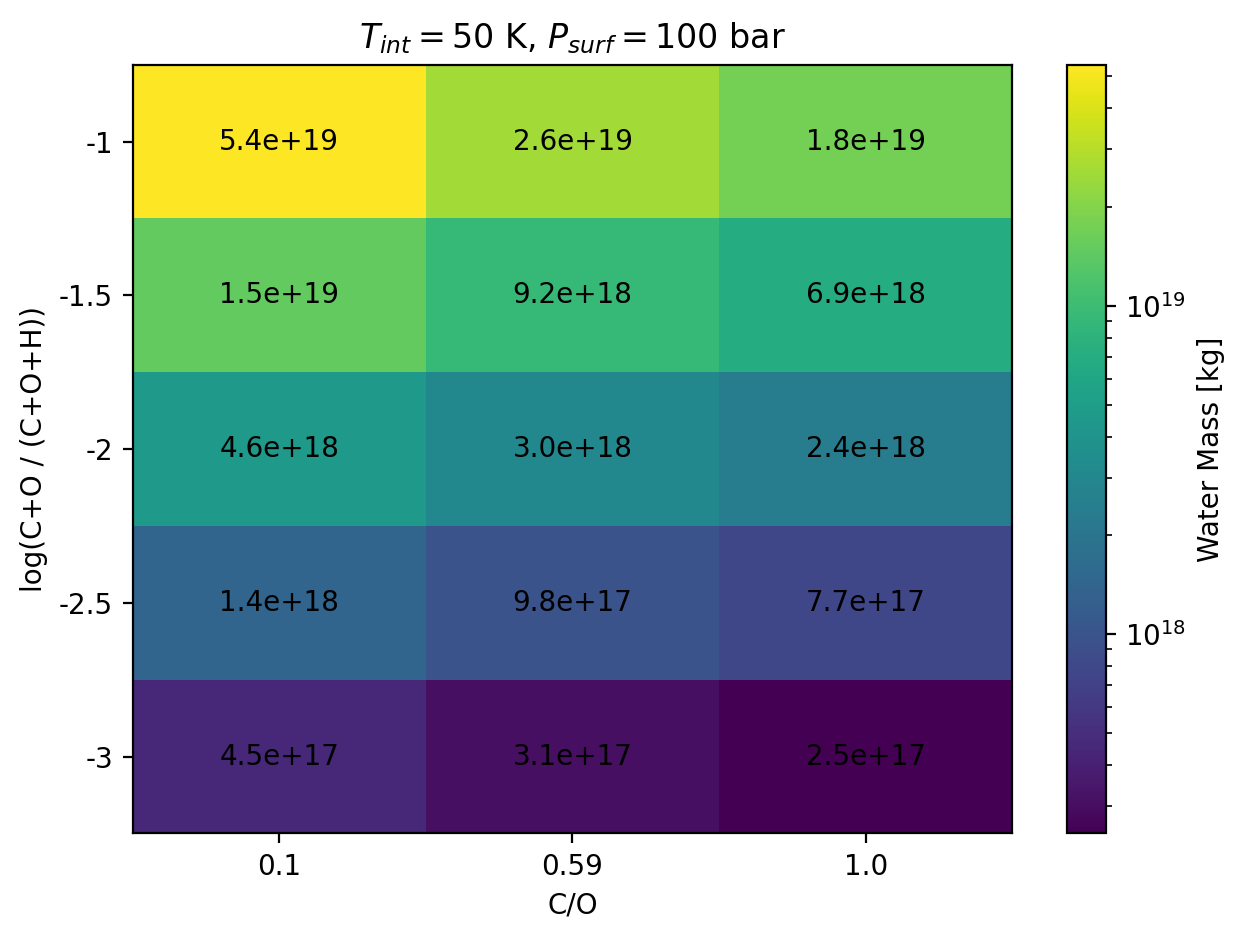

In [66]:
i_temp = 0
i_press = 2

data_matrix_h2o, data_matrix_h2o_l = get_total_liquid_water_mass(i_temp, i_press, combine=True, planet='Earth')
#data_matrix_h2o /= earth_ocean
#data_matrix_h2o_l /= earth_ocean
data_matrix_h2o /= 1e3  # convert to kg

title = r"$T_{int} = $" + f"{Tints[i_temp]} K, " + r"$P_{surf} = $" + f"{P0s[i_press]/1e6:g} bar"
plot_other(data_matrix_h2o, title, 'Water Mass [kg]', log=True, segmented=False, vmin=None, vmax=None, layer=0, display_text=True)